#AI DAY - Transformers Workshop
##Fine tune a translation model

**NOTE**: There are a few pieces of code missing in this notebook, you need to go through it and fill it in, we will eventually go through it all together in the live workshop session.

if you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it

In [1]:
#!pip install datasets transformers[sentencepiece] sacrebleu

     |████████████████████████████████| 311 kB 9.9 MB/s 
     |████████████████████████████████| 3.4 MB 65.7 MB/s 
     |████████████████████████████████| 90 kB 14.6 MB/s 
     |████████████████████████████████| 133 kB 84.3 MB/s 
     |████████████████████████████████| 243 kB 74.9 MB/s 
     |████████████████████████████████| 1.1 MB 67.9 MB/s 
     |████████████████████████████████| 67 kB 8.2 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
     |████████████████████████████████| 3.3 MB 53.1 MB/s 
     |████████████████████████████████| 895 kB 78.2 MB/s 
     |████████████████████████████████| 271 kB 75.2 MB/s 
     |████████████████████████████████| 144 kB 80.0 MB/s 
     |████████████████████████████████| 160 kB 77.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13




If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up here if you haven't already!) then execute the following cell and input your username and password:


In [32]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Then you need to install Git-LFS. Uncomment the following instructions:


In [36]:
#!apt install git-lfs


##Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the 🤗 Transformers model for a translation task. We will use the [WMT](https://www.statmt.org/wmt16/) dataset, a machine translation dataset composed from a collection of various sources, including news commentaries and parliament proceedings.
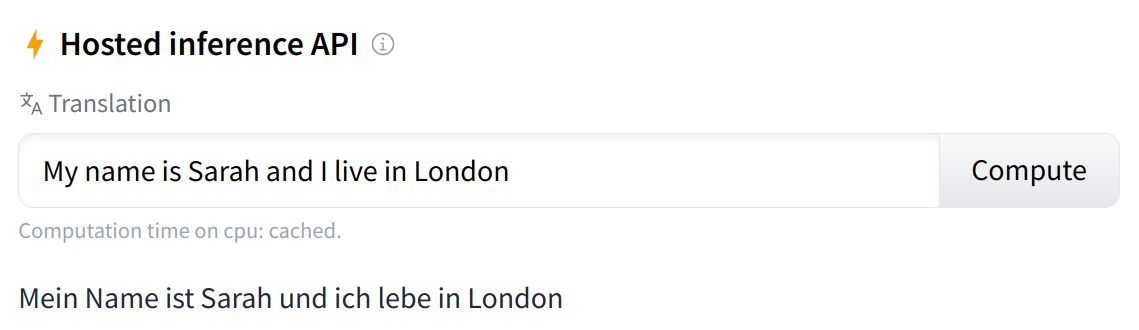

We will see how to easily load the dataset for this task using 🤗 Datasets and how to fine-tune a model on it using the Trainer API.

In [37]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-ro"

Here we picked the Helsinki-NLP/opus-mt-en-ro" checkpoint.


##Loading the dataset

We will use the 🤗 *Datasets* library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`. We use the English/Romanian part of the WMT dataset here.


In [38]:
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("wmt16", "ro-en")
metric = load_metric("sacrebleu")

Reusing dataset wmt16 (/root/.cache/huggingface/datasets/wmt16/ro-en/1.0.0/9e0038fe4cc117bd474d2774032cc133e355146ed0a47021b2040ca9db4645c0)


  0%|          | 0/3 [00:00<?, ?it/s]

The `dataset` object itself is `DatasetDict`, which contains one key for the training, validation and test set:

In [39]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 610320
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
})

To access an actual element, you need to select a split first, then give an index:


In [40]:
raw_datasets["train"][0]

{'translation': {'en': 'Membership of Parliament: see Minutes',
  'ro': 'Componenţa Parlamentului: a se vedea procesul-verbal'}}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.


In [41]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [42]:
show_random_elements(raw_datasets["train"])

,translation
0,"{'en': 'A review of sports, entertainment and other cultural news from the Balkans since 7 May:', 'ro': 'O retrospectivă a evenimentelor din sport, divertisment şi alte informaţii culturale din Balcani, din 7 mai:'}"
1,"{'en': 'One of the issues discussed during a meeting between the two countries' delegations, headed by Sanader and BiH Council of Ministers Chairman Nikola Spiric, concerned the dispute over the use of the southern Croatian seaport of Ploce.', 'ro': 'Una din chestiunile discutate în cursul întâlnirii dintre delegaţiile celor două ţări, conduse de Sanader şi de preşedintele Consiliului de Miniştri al BiH Nikola Spiric, s-a referit la disputa legată de utilizarea portului Ploce din sudul Croaţiei.'}"
2,"{'en': 'Economic convergence, monitoring of the national budgetary and structural policy options, new instruments for financial market monitoring - all of this may give the impression that the apparatus of the Union is on the way to becoming pretty heavy-going and complicated.', 'ro': 'Convergenţa economică, monitorizarea opţiunilor naţionale de politică bugetară şi structurală, noile instrumente pentru monitorizarea pieţei financiare - toate acestea pot da impresia că aparatul Uniunii este pe cale să devină destul de greoi şi complicat.'}"
3,"{'en': 'This then limits the possibilities for investment, for example, in new rolling stock.', 'ro': 'La rândul său, acest lucru limitează posibilităţile de investiţii în noi materiale rulante, de pildă.'}"
4,"{'en': 'Yes?', 'ro': 'Da?'}"


The metric is an instance of `datasets.Metric`:

In [43]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: The system stream (a sequence of segments).
    references: A list of one or more reference streams (each a sequence of segments).
    smooth_method: The smoothing method to use. (Default: 'exp').
    smooth_value: The smoothing value. Only valid for 'floor' and 'add-k'. (Defaults: floor: 0.1, add-k: 1).
    tokenize: Tokenization method to use for BLEU. If not provided, defaults to 'zh' for Chinese, 'ja-mecab' for
        Japanese and '13a' (mteval) otherwise.
    lowercase: Lowercase the data. If True, enables case-insensitivity. (Default: False).
    force: Insist that your tokenized input is actually detokenized.

Returns:
    'score': BLEU score,
    'counts'


##Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

* we get a tokenizer that corresponds to the model architecture we want to use,
* we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.


In [12]:
###WERITE YOUR CODE HERE (Don't forget to import what you need)

tokenizer = 
###

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/770k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

In [13]:
tokenizer

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-ro', vocab_size=59543, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

For the mBART tokenizer (like we have here), we need to set the source and target languages (so the texts are preprocessed properly).

In [14]:
if "mbart" in model_checkpoint:
  tokenizer.source_lang="en-XX"
  tokenizer.target_lang = "ro-RO"


By default, the call above will use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library.

You can directly call this tokenizer on one sentence or a pair of sentences:


In [15]:
tokenizer("Hello AI DAY folks, this is one sentence!")

{'input_ids': [125, 778, 67, 317, 27767, 7100, 11, 3, 63, 32, 141, 9191, 23, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later).

Instead of one sentence, we can pass along a list of sentences:

In [16]:
tokenizer(["Hello AI DAY folks, this is one sentence!", "This is another sentence."])

{'input_ids': [[125, 778, 67, 317, 27767, 7100, 11, 3, 63, 32, 141, 9191, 23, 0], [187, 32, 716, 9191, 2, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the `as_target_tokenizer` context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

try this at this two sentences : 
```python
["Hello AI DAY folks, this is one sentence!", "This is another sentence."]
```

In [18]:
###WRITE YOUR CODE HERE
with 
##

{'input_ids': [[10334, 1204, 18216, 8899, 1289, 6775, 105, 3792, 3, 15, 8915, 32, 27, 452, 59, 29579, 581, 23, 0], [235, 1705, 11, 32, 8, 1205, 5305, 59, 29579, 581, 2, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


If you are using one of the five T5 checkpoints that require a special prefix to put before the inputs, you should adapt the following cell.

In [19]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "translate English to Romanian: "
else:
    prefix = ""

We can then write the function that will preprocess our samples. We just feed them to the tokenizer with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

Complete the code bellow:

1. Tokenize the inputs by setting the `max_length` to `max_target_length`.
2. Setup labels using `as_target_tokenizer` context manager

In [20]:
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "ro"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    ###TOKINIZE YOUR INPUTS
    model_inputs = 
    ##
    
    # Setup the tokenizer for targets
    ##WRITE YOUR CODE HERE
      
      labels = 
    ##

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs



This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [21]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[393, 4462, 14, 1137, 53, 216, 28636, 0], [24385, 14, 28636, 14, 4646, 4622, 53, 216, 28636, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[42140, 494, 1750, 53, 8, 59, 903, 3543, 9, 15202, 0], [36199, 6612, 9, 15202, 122, 568, 35788, 21549, 53, 8, 59, 903, 3543, 9, 15202, 0]]}

To apply this function on all the pairs of sentences in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command.


In [22]:
###WRITE YOUR CODE HERE (TURN batched to True)
tokenized_datasets = 
##

  0%|          | 0/611 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to map to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.


##Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the `AutoModelForSeq2SeqLM` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.


In [23]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
###Write your code here
model = 
##


Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

To instantiate a `Seq2SeqTrainer`, we will need to define three more things. The most important is the `Seq2SeqTrainingArguments`, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [24]:


batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)



Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the cell and customize the weight decay. Since the `Seq2SeqTrainer` will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the `predict_with_generate` option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

The last argument to setup everything so we can push the model to the Hub regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"Aymen311/trslt-finetuned-en-to-ro"` or `"SOAI/trslt-finetuned-en-to-ro"`).

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our `Seq2SeqTrainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:


In [27]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`:

you'll have to pass the model, arguments, train dataset, eval dataset, datacollator, tokenizer and the compute metrics

In [33]:
###Write your code here
trainer = 
##

Cloning https://huggingface.co/Aymene/opus-mt-en-ro-finetuned-en-to-ro into local empty directory.
Using amp half precision backend


We can now finetune our model by just calling the `train` method:

In [35]:
###Write your code here 

##

The following columns in the training set  don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation.
***** Running training *****
  Num examples = 610320
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 38145


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()



You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier "your-username/the-name-you-picked" so for instance:

```python
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("SOAI/my-awesome-model")
```

